In [1]:
# define k, sites, and customers
k = 5                 # desired number of facilities
I = list(range(1000)) # customers: 0, 1, 2, ..., 999
J = list(range(1000)) # candidate sites: 0, 1, 2, ..., 999

In [2]:
# For convenience, pick the sites (x,y-coordinates) at random
import random

# random.random() gives pseudorandom number from [0,1]
J_x = [ random.random() for j in J ]
J_y = [ random.random() for j in J ]

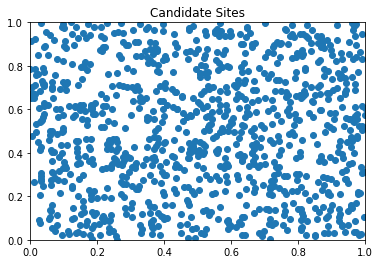

In [3]:
# Draw the sites using matplotlib
import matplotlib.pyplot as plt

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(J_x,J_y)
plt.title('Candidate Sites')
plt.show()

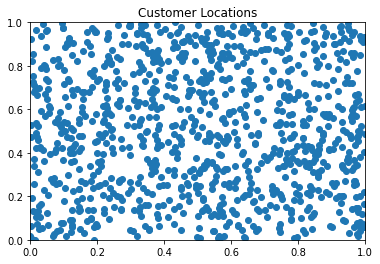

In [4]:
# Draw the customer locations
I_x = [ random.random() for i in I ]
I_y = [ random.random() for i in I ]

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(I_x,I_y)
plt.title('Customer Locations')
plt.show()

In [5]:
# Suppose that cost equals rectilinear distance
# returns rectilinear distance between (x1,y1) and (x2,y2)
def rect_dist(x1,y1,x2,y2):
    return abs(x1-x2) + abs(y1-y2)

def c(i,j):
    return rect_dist( I_x[i], I_y[i], J_x[j], J_y[j] )

In [6]:
# import gurobi
import gurobipy as gp
from gurobipy import GRB

In [7]:
#############################################
# First, let's solve the monolithic LP model
#############################################

# create model 
m = gp.Model()

# create variables, x[i,j] = 1 if customer i is assigned to site j
x = m.addVars( I, J )

# create variables, y[j] = 1 if site j is used
y = m.addVars( J )
for j in J:
    y[j].ub = 1

# Objective: minimize assignment cost
m.setObjective( gp.quicksum( c(i,j) * x[i,j] for i in I for j in J ) , GRB.MINIMIZE )

# Constraint: pick k sites
m.addConstr( gp.quicksum( y ) == k )

# Constraints: each customer assigned to one site
m.addConstrs( gp.quicksum( x[i,j] for j in J ) == 1 for i in I )

# Constraints: if site j is not used, then no customer can be assigned to it
m.addConstrs( x[i,j] <= y[j] for i in I for j in J )

# force Gurobi to use concurrent method (primal simplex, dual simplex, barrier all at the same time!)
m.Params.Method = 3 

# solve
m.optimize()

m_time = m.runtime

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Set parameter Method to value 3
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1001001 rows, 1001000 columns and 3001000 nonzeros
Model fingerprint: 0xb0d2210b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 1.76s
Presolved: 1001001 rows, 1001000 columns, 3001000 nonzeros

Ordering time: 0.46s

Barrier statistics:
 Dense cols : 1000
 AA' NZ     : 2.001e+06
 Factor NZ  : 4.514e+06 (roughly 800 MB of memory)
 Factor Ops : 1.369e+09 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual    

In [8]:
#############################################
# Now, let's use Benders instead
#############################################

# create main model 
main = gp.Model()
main.Params.OutputFlag = 0

# create variables, y[j] = 1 if site j is used
y = main.addVars( J )
for j in J:
    y[j].ub = 1

# Objective: minimize assignment cost
z = main.addVar()
z.lb = 0
main.setObjective( z, GRB.MINIMIZE )

# Constraint: pick k sites
main.addConstr( gp.quicksum( y ) == k )

main.update()

In [9]:
# create function to get Benders cut 
#
# To do so, we solve Benders subproblem.
# For implementaion simplicity, we solve it as an LP,
#   although a combinatorial algorithm would be faster.
#
def get_Benders_cut(y_bar_sparse):
    
    sub = gp.Model()
    sub.Params.OutputFlag = 0
    
    # only create x[i,j] variable when y[j] > 0
    J_sparse = list(y_bar_sparse.keys())
    x = sub.addVars( J_sparse )
    assignment_constraint = sub.addConstr( gp.quicksum( x[j] for j in J_sparse ) == 1 )
    bound_constraints = sub.addConstrs( x[j] <= y_bar_sparse[j] for j in J_sparse )
    
    alpha_bar = { i : 0 for i in I }
    sub_time = 0
    sub_obj = 0

    for i in I:
        sub.setObjective( gp.quicksum( c(i,j) * x[j] for j in J_sparse ), GRB.MINIMIZE )
        sub.optimize()
        sub_time += sub.runtime
        sub_obj += sub.objVal
        alpha_bar[i] = assignment_constraint.Pi
        #sub.reset()
    
    # compute benders cut coefficients
    # the coef of y[j] is:
    #    sum( beta_bar[i,j] for i in I )
    # where 
    #    beta_bar[i,j] = min( 0, c(i,j) - alpha_bar[i] )
    benders_coef = { j : sum( min( 0, c(i,j) - alpha_bar[i] ) for i in I ) for j in J }
    sum_alpha = sum( alpha_bar[i] for i in I )
    
    return ( sub_obj, sum_alpha, benders_coef, sub_time )

In [10]:
# NOW START THE ALGORITHM
import time
optimality_tolerance = 0.0001

main_obj = 0                        # dummy value
sub_obj = 2 * optimality_tolerance  # dummy value
iteration = 0

print("Iter. \t main_obj \t sub_obj \t time")
benders_start = time.time()
main_time = 0 
sub_time = 0

# initial stabilizer
y_old_sparse = { j : 1 for j in range(k) }   # sparse stabilizer
#y_old_sparse = { j : k/len(J) for j in J }    # "uniform prior" stabilizer

while sub_obj - main_obj > optimality_tolerance:
    
    iteration += 1
    
    # solve main problem
    main.optimize()
    main_time += main.runtime
    y_bar_sparse = { j : y[j].x for j in J if y[j].x > 0 }
    main_obj = z.x
    
    # get midpoint between y_bar and y_old
    y_mid = { j : 0 for j in J }
    for j in y_bar_sparse.keys():
        y_mid[j] += 0.5 * y_bar_sparse[j]
    for j in y_old_sparse.keys():
        y_mid[j] += 0.5 * y_old_sparse[j]
    y_mid_sparse = { j : y_mid[j] for j in J if y_mid[j] > 0 }
    y_old_sparse = y_bar_sparse
    
    # get Benders cut by solving subproblem
    ( sub_obj, sum_alpha, benders_coef, cut_time ) = get_Benders_cut(y_mid_sparse)
    sub_time += cut_time
    
    # add benders cut to main problem
    main.addConstr( z >= sum_alpha + gp.quicksum( benders_coef[j] * y[j] for j in J ) )
    
    print(iteration,'\t','{0:.4f}'.format(main_obj),'\t','{0:.4f}'.format(sub_obj),'\t','{0:.2f}'.format(time.time() - benders_start))

benders_end = time.time()

Iter. 	 main_obj 	 sub_obj 	 time
1 	 0.0000 	 266.1968 	 0.76
2 	 137.7907 	 322.2735 	 1.49
3 	 141.3156 	 385.7968 	 2.30
4 	 161.0266 	 347.6119 	 3.10
5 	 162.7445 	 347.5559 	 3.82
6 	 167.4079 	 277.4251 	 4.54
7 	 174.8291 	 272.5478 	 5.37
8 	 179.1254 	 272.3933 	 6.09
9 	 180.2788 	 265.9318 	 6.82
10 	 187.0214 	 263.3410 	 7.57
11 	 189.8824 	 268.1691 	 8.40
12 	 191.9040 	 255.4327 	 9.13
13 	 192.4300 	 259.2331 	 9.88
14 	 195.2572 	 239.9450 	 10.64
15 	 196.9914 	 240.3440 	 11.40
16 	 200.5496 	 242.9903 	 12.17
17 	 201.0090 	 252.6312 	 12.92
18 	 201.6273 	 239.6910 	 13.66
19 	 203.3574 	 239.2807 	 14.48
20 	 205.4729 	 234.5825 	 15.23
21 	 208.6355 	 231.8924 	 16.03
22 	 209.4656 	 237.3618 	 16.85
23 	 210.9012 	 232.2323 	 17.61
24 	 211.1067 	 236.4088 	 18.39
25 	 212.4441 	 232.6088 	 19.20
26 	 212.9150 	 233.8171 	 19.94
27 	 213.2725 	 235.7080 	 20.70
28 	 213.8978 	 233.3293 	 21.46
29 	 214.1044 	 230.8240 	 22.21
30 	 215.4562 	 230.0687 	 23.00


In [11]:
print("\nFinally, we have y =",y_bar_sparse)

print("\nMain problem time (Gurobi) =",'{0:.2f}'.format(main_time))
print("\nSubproblem time (Gurobi) =",'{0:.2f}'.format(sub_time))
print("\nTotal Benders time =",'{0:.2f}'.format(benders_end - benders_start))

print("\nTotal monolithic time (Gurobi) =",'{0:.2f}'.format(m_time) )


Finally, we have y = {15: 7.550255444082089e-13, 123: 2.6299457431596565e-13, 212: 2.0438392388595027e-12, 315: 1.5615983757136474e-13, 320: 1.6293968000134581e-12, 358: 0.9999999999984821, 420: 0.9999999999974528, 463: 0.9999999999991893, 519: 1.8259695090461496e-12, 563: 1.4167278210859196e-12, 666: 0.9999999999984862, 698: 5.648404143356383e-13, 704: 1.7278352580047224e-13, 813: 1.381251832123125e-13, 878: 0.9999999999991883, 890: 1.8864826076975274e-13}

Main problem time (Gurobi) = 1.27

Subproblem time (Gurobi) = 14.75

Total Benders time = 188.50

Total monolithic time (Gurobi) = 69.80
